In [10]:
%matplotlib inline
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import SimpleITK as sitk
import tensorflow as tf
from sklearn import feature_extraction
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D,AveragePooling2D, GlobalMaxPool2D
from skimage.segmentation import mark_boundaries,slic

In [49]:
def get_data(filename):
    img = nib.load(filename)
    return img.get_data(), img.affine
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))
mri_data = get_data('case_001_2.nii.gz')[0].swapaxes(0,2)
labelled_data = get_data('tumor.nii.gz')[0].swapaxes(0,2)
shape = labelled_data.shape
#mri_data = scale(mri_data.reshape((shape[0],shape[1],shape[2],1)))

In [3]:
# output = 1 if slice has a tumor
y_train = np.sum(labelled_data,axis=(1,2))>0

In [105]:
segments = slic(mri_data,25,multichannel=False,sigma=1)

In [107]:
segments.max() # of segments

14

(-0.5, 287.5, 319.5, -0.5)

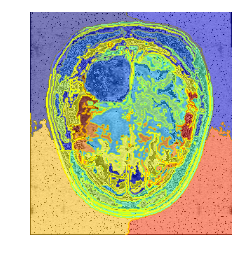

In [114]:
fig = plt.figure("Superpixels -- %d segments" % (10))
ax = fig.add_subplot(1, 1, 1)
n=26
ax.imshow(mark_boundaries(mri_data[n], segments[n]))
ax.imshow(segments[n],alpha=.5)
plt.axis("off")

In [156]:
'''
Generate features based on segmented superpixels
- Center of grouping
- Variance
- Volume
'''
def normalize(x):
    return x / x.max(axis=0)
# Training data = number of segments per image
# labelled data = 1 if over threshold% of voxels in the segment are part of the tumor
def extract_features(segments, labels=None, threshold=.1):
    num_segments = segments.max()+1
    x_train = np.zeros((num_segments,3))
    y_train = np.zeros(num_segments)
    for i in range(num_segments):
        x,y,z = np.where(segments==i)
        locations = np.concatenate((x.reshape(x.size,1),y.reshape(y.size,1),z.reshape(z.size,1)),axis=1)
        x_train[i]=[locations.mean(), np.var(locations), locations.shape[0]*1./segments.size]
        if labels is not None and np.sum(labelled_data[x,y,z])>labelled_data[x,y,z].size*threshold:
            y_train[i] = 1
        else:
            y_train[i] = 0
    return normalize(x_train), y_train

In [157]:
X,Y = extract_features(segments,labelled_data)

In [150]:
X

array([[  3.79632911e+01,   1.84809077e+03,   7.48494055e-02],
       [  1.12566844e+02,   1.18683493e+04,   7.45156645e-02],
       [  7.81153901e+01,   5.77282098e+03,   9.93653988e-02],
       [  7.44990201e+01,   5.18375569e+03,   4.84864925e-02],
       [  9.46810539e+01,   5.48335992e+03,   7.17776726e-02],
       [  9.21878633e+01,   4.97789959e+03,   5.08157749e-02],
       [  1.26784181e+02,   9.00277773e+03,   5.85003683e-02],
       [  9.01811326e+01,   4.14533558e+03,   3.27007050e-02],
       [  1.17074550e+02,   1.11717433e+04,   4.28520228e-02],
       [  1.17399067e+02,   8.59721656e+03,   1.14050992e-01],
       [  1.11579441e+02,   1.36205352e+04,   9.94933055e-02],
       [  1.18185479e+02,   7.24830135e+03,   4.07236427e-02],
       [  1.73066354e+02,   1.36566049e+04,   1.06229614e-01],
       [  1.24936810e+02,   7.47716617e+03,   3.18454730e-02],
       [  9.66474268e+01,   5.50290581e+03,   5.37934685e-02]])

In [122]:
x,y,z = np.where(segments==3)
#d = np.concatenate((x.reshape(x.size,1),y.reshape(y.size,1),z.reshape(z.size,1)),axis=1)
#np.var(d)
print labelled_data[x,y,z]
print np.sum(labelled_data[x,y,z]), labelled_data[x,y,z].size

[0 0 0 ..., 0 0 0]
19161 147461


In [158]:
model = Sequential()
model.add(Dense(5,input_shape=[3]))
model.add(Activation('relu'))
#model.add(Dense(20,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',metrics=['accuracy'])
print model.summary()
model.fit(X,Y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5)                 20        
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 6         
Total params: 86.0
Trainable params: 86.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/10
15/15 [==============================] - 0s - loss: 0.6579 - acc: 0.9333
Epoch 2/10
15/15 [==============================] -

In [153]:
predict = model.predict(extract_features(segments)[0])

In [154]:
predict

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]], dtype=float32)

In [16]:
y_train

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False], dtype=bool)